<a href="https://colab.research.google.com/github/Nirzu97/pyprobml/blob/matrix-factorization/notebooks/matrix_factorization_recommender_surprise_lib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Factorization for Movie Lens Recommendations using Surprise library









In [109]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Surprise library for collaborative filtering

http://surpriselib.com/
Simple Python RecommendatIon System Engine


In [110]:
!pip install surprise

In [111]:
import surprise

In [112]:
from surprise import Dataset

data = Dataset.load_builtin("ml-1m")

In [113]:
trainset = data.build_full_trainset()

In [114]:
print([trainset.n_users, trainset.n_items, trainset.n_ratings])

[6040, 3706, 1000209]


# Setting Up the Ratings Data

We read the data directly from MovieLens website, since they don't allow redistribution. We want to include the metadata (movie titles, etc), not just the ratings matrix.


In [115]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m
!ls
folder = "ml-1m"

--2021-04-20 14:51:23--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.4’

ml-1m.zip.4         100%[===================>]   5.64M  6.80MB/s    in 0.8s    

2021-04-20 14:51:24 (6.80 MB/s) - ‘ml-1m.zip.4’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
ml-1m	   ml-1m.zip.1	ml-1m.zip.3  sample_data
ml-1m.zip  ml-1m.zip.2	ml-1m.zip.4


In [116]:
ratings_list = [
    [int(x) for x in i.strip().split("::")] for i in open(os.path.join(folder, "ratings.dat"), "r").readlines()
]
users_list = [i.strip().split("::") for i in open(os.path.join(folder, "users.dat"), "r").readlines()]
movies_list = [
    i.strip().split("::") for i in open(os.path.join(folder, "movies.dat"), "r", encoding="latin-1").readlines()
]

In [117]:
ratings_df = pd.DataFrame(ratings_list, columns=["UserID", "MovieID", "Rating", "Timestamp"], dtype=int)
movies_df = pd.DataFrame(movies_list, columns=["MovieID", "Title", "Genres"])
movies_df["MovieID"] = movies_df["MovieID"].apply(pd.to_numeric)

In [118]:
movies_df.head()

MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

In [119]:
def get_movie_name(movies_df, movie_id_str):
    ndx = movies_df["MovieID"] == int(movie_id_str)
    name = movies_df["Title"][ndx].to_numpy()[0]
    return name


print(get_movie_name(movies_df, 1))
print(get_movie_name(movies_df, "527"))

Toy Story (1995)
Schindler's List (1993)


In [120]:
def get_movie_genres(movies_df, movie_id_str):
    ndx = movies_df["MovieID"] == int(movie_id_str)
    name = movies_df["Genres"][ndx].to_numpy()[0]
    return name


print(get_movie_genres(movies_df, 1))
print(get_movie_genres(movies_df, "527"))

Animation|Children's|Comedy
Drama|War


In [121]:
ratings_df.head()

UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

In [122]:
iter = trainset.all_ratings()
nshow = 5
counter = 0
for item in iter:
    # print(item)
    (uid_inner, iid_inner, rating) = item
    # Raw ids are strings that match the external ratings file
    uid_raw = trainset.to_raw_uid(uid_inner)
    iid_raw = trainset.to_raw_iid(iid_inner)
    print(
        "uid inner {}, raw {}, iid inner {}, raw {}, rating {}".format(uid_inner, uid_raw, iid_inner, iid_raw, rating)
    )
    counter += 1
    if counter > nshow:
        break

uid inner 0, raw 1, iid inner 0, raw 1193, rating 5.0
uid inner 0, raw 1, iid inner 1, raw 661, rating 3.0
uid inner 0, raw 1, iid inner 2, raw 914, rating 3.0
uid inner 0, raw 1, iid inner 3, raw 3408, rating 4.0
uid inner 0, raw 1, iid inner 4, raw 2355, rating 5.0
uid inner 0, raw 1, iid inner 5, raw 1197, rating 3.0


In [123]:
iid_raw = str(1318)

items_raw = list(trainset.to_raw_iid(i) for i in trainset.all_items())
print(items_raw[:10])
print(type(items_raw[0]))
print(len(np.unique(items_raw)))

['1193', '661', '914', '3408', '2355', '1197', '1287', '2804', '594', '919']
<class 'str'>
3706


In [124]:
users_raw = list(trainset.to_raw_uid(i) for i in trainset.all_users())
print(users_raw[:10])
print(len(np.unique(users_raw)))

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
6040


In [125]:
# inspect user ratings for user 837
uid_raw = str(837)
uid_inner = trainset.to_inner_uid(uid_raw)
user_ratings = trainset.ur[uid_inner]
print(len(user_ratings))
print(user_ratings)
rated_raw = [trainset.to_raw_iid(iid) for (iid, rating) in user_ratings]
print(rated_raw)
unrated_raw = list(set(items_raw) - set(rated_raw))
print(len(unrated_raw))

69
[(1231, 3.0), (1113, 3.0), (559, 4.0), (97, 3.0), (255, 3.0), (1240, 2.0), (597, 4.0), (631, 1.0), (1448, 3.0), (1195, 3.0), (540, 3.0), (338, 5.0), (54, 4.0), (78, 3.0), (246, 3.0), (985, 3.0), (266, 3.0), (275, 2.0), (1454, 2.0), (159, 3.0), (859, 5.0), (156, 4.0), (1237, 2.0), (244, 3.0), (99, 4.0), (104, 3.0), (151, 3.0), (1456, 3.0), (199, 4.0), (1891, 2.0), (945, 3.0), (88, 4.0), (799, 3.0), (617, 3.0), (1450, 4.0), (213, 5.0), (669, 5.0), (1922, 4.0), (92, 3.0), (1518, 3.0), (1529, 3.0), (829, 2.0), (1468, 3.0), (132, 1.0), (955, 3.0), (1249, 3.0), (882, 3.0), (167, 4.0), (315, 3.0), (41, 4.0), (381, 4.0), (210, 4.0), (2451, 3.0), (135, 3.0), (1511, 3.0), (15, 4.0), (711, 3.0), (215, 2.0), (1475, 4.0), (216, 3.0), (728, 4.0), (1154, 3.0), (67, 4.0), (434, 5.0), (1228, 3.0), (48, 5.0), (546, 4.0), (1009, 2.0), (170, 3.0)]
['1248', '2991', '1252', '589', '6', '1267', '1276', '1292', '905', '910', '1446', '913', '3068', '1610', '1617', '942', '3083', '2289', '955', '3095', '3417

# Join with meta data

In [126]:
def get_true_ratings(uid_raw, trainset):
    uid_inner = trainset.to_inner_uid(uid_raw)
    user_ratings = trainset.ur[uid_inner]
    item_list = [trainset.to_raw_iid(iid) for (iid, rating) in user_ratings]
    rating_list = [rating for (iid, rating) in user_ratings]
    item_list = np.array(item_list)
    rating_list = np.array(rating_list)
    ndx = np.argsort([-r for r in rating_list])  # largest (most negative) first
    return item_list[ndx], rating_list[ndx]


def make_predictions(algo, uid_raw, trainset):
    uid_inner = trainset.to_inner_uid(uid_raw)
    user_ratings = trainset.ur[uid_inner]
    rated_raw = [trainset.to_raw_iid(iid) for (iid, rating) in user_ratings]
    items_raw = list(trainset.to_raw_iid(i) for i in trainset.all_items())
    unrated_raw = list(set(items_raw) - set(rated_raw))
    item_list = []
    rating_list = []
    for iid_raw in unrated_raw:
        pred = algo.predict(uid_raw, iid_raw, verbose=False)
        uid_raw, iid_raw, rating_true, rating_pred, details = pred
        item_list.append(iid_raw)
        rating_list.append(rating_pred)
    item_list = np.array(item_list)
    rating_list = np.array(rating_list)
    ndx = np.argsort([-r for r in rating_list])  # largest (most negative) first
    return item_list[ndx], rating_list[ndx]


def make_df(movies_df, item_list_raw, rating_list):
    name_list = []
    genre_list = []
    for i in range(len(item_list_raw)):
        item_raw = item_list_raw[i]
        name = get_movie_name(movies_df, item_raw)
        genre = get_movie_genres(movies_df, item_raw)
        name_list.append(name)
        genre_list.append(genre)
    df = pd.DataFrame({"name": name_list, "genre": genre_list, "rating": rating_list, "iid": item_list_raw})
    return df

In [127]:
uid_raw = str(837)

item_list_raw, rating_list = get_true_ratings(uid_raw, trainset)
df = make_df(movies_df, item_list_raw, rating_list)
df.head(10)

name  ...   iid
0                                Jaws (1975)  ...  1387
1                 Saving Private Ryan (1998)  ...  2028
2             Godfather: Part II, The (1974)  ...  1221
3                 Maltese Falcon, The (1941)  ...   913
4                 Crimson Pirate, The (1952)  ...  3417
5                      Godfather, The (1972)  ...   858
6                Strangers on a Train (1951)  ...  2186
7                   Strictly Ballroom (1992)  ...  1188
8  Butch Cassidy and the Sundance Kid (1969)  ...  1304
9           Shawshank Redemption, The (1994)  ...   318

[10 rows x 4 columns]

# Fit/ predict

In [128]:
# https://surprise.readthedocs.io/en/stable/matrix_factorization.html
algo = surprise.SVD(n_factors=50, biased=True, n_epochs=20, random_state=42, verbose=True)
algo.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [129]:
uid_raw = str(837)

item_list_raw, rating_list = make_predictions(algo, uid_raw, trainset)
df = make_df(movies_df, item_list_raw, rating_list)
df.head(10)

name  ...   iid
0                     Schindler's List (1993)  ...   527
1                           Casablanca (1942)  ...   912
2                              Sanjuro (1962)  ...  2905
3              Raiders of the Lost Ark (1981)  ...  1198
4   Star Wars: Episode IV - A New Hope (1977)  ...   260
5                           Sting, The (1973)  ...  1234
6                          Rear Window (1954)  ...   904
7                It's a Wonderful Life (1946)  ...   953
8                   Lawrence of Arabia (1962)  ...  1204
9  Life Is Beautiful (La Vita è bella) (1997)  ...  2324

[10 rows x 4 columns]

# Visualize matrix of predictions

In [130]:
# inspect user ratings for user 837
uid_raw = str(837)
uid_inner = trainset.to_inner_uid(uid_raw)
user_ratings = trainset.ur[uid_inner]
print(len(user_ratings))
print(user_ratings)
ratings_raw = [rating for (iid, rating) in user_ratings]
rated_raw = [trainset.to_raw_iid(iid) for (iid, rating) in user_ratings]
print(rated_raw)
print(trainset.to_raw_iid(1231))
print(ratings_raw[0])

69
[(1231, 3.0), (1113, 3.0), (559, 4.0), (97, 3.0), (255, 3.0), (1240, 2.0), (597, 4.0), (631, 1.0), (1448, 3.0), (1195, 3.0), (540, 3.0), (338, 5.0), (54, 4.0), (78, 3.0), (246, 3.0), (985, 3.0), (266, 3.0), (275, 2.0), (1454, 2.0), (159, 3.0), (859, 5.0), (156, 4.0), (1237, 2.0), (244, 3.0), (99, 4.0), (104, 3.0), (151, 3.0), (1456, 3.0), (199, 4.0), (1891, 2.0), (945, 3.0), (88, 4.0), (799, 3.0), (617, 3.0), (1450, 4.0), (213, 5.0), (669, 5.0), (1922, 4.0), (92, 3.0), (1518, 3.0), (1529, 3.0), (829, 2.0), (1468, 3.0), (132, 1.0), (955, 3.0), (1249, 3.0), (882, 3.0), (167, 4.0), (315, 3.0), (41, 4.0), (381, 4.0), (210, 4.0), (2451, 3.0), (135, 3.0), (1511, 3.0), (15, 4.0), (711, 3.0), (215, 2.0), (1475, 4.0), (216, 3.0), (728, 4.0), (1154, 3.0), (67, 4.0), (434, 5.0), (1228, 3.0), (48, 5.0), (546, 4.0), (1009, 2.0), (170, 3.0)]
['1248', '2991', '1252', '589', '6', '1267', '1276', '1292', '905', '910', '1446', '913', '3068', '1610', '1617', '942', '3083', '2289', '955', '3095', '3417

In [131]:
def get_rating(trainset, uid_raw, iid_raw):
    uid_inner = trainset.to_inner_uid(uid_raw)
    user_ratings = trainset.ur[uid_inner]
    rated_iid_raw = np.array([trainset.to_raw_iid(iid) for (iid, rating) in user_ratings])
    ratings = np.array([rating for (iid, rating) in user_ratings])
    ndx = np.where(rated_iid_raw == iid_raw)[0]
    if len(ndx) > 0:
        return ratings[ndx][0]
    else:
        return 0


print(get_rating(trainset, "837", "1201"))
print(get_rating(trainset, "837", "0"))

2.0
0


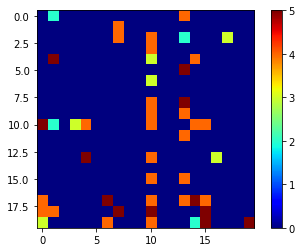

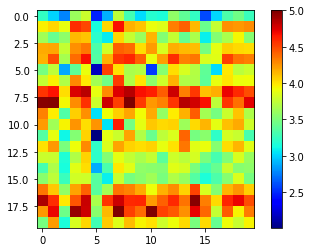

In [132]:
users_raw = list(trainset.to_raw_uid(i) for i in trainset.all_users())
items_raw = list(trainset.to_raw_iid(i) for i in trainset.all_items())

users_raw = ["837"] + users_raw
items_raw = [str(i) for i in range(1200, 1300)]
nusers = 20
nitems = 20

Rtrue = np.zeros((nusers, nitems))
Rpred = np.zeros((nusers, nitems))
for ui in range(nusers):
    for ii in range(nitems):
        uid = users_raw[ui]
        iid = items_raw[ii]
        pred = algo.predict(uid, iid, verbose=False)
        uid_raw, iid_raw, _, rating_pred, details = pred
        Rpred[ui, ii] = rating_pred
        Rtrue[ui, ii] = get_rating(trainset, uid_raw, iid_raw)


plt.figure()
plt.imshow(Rtrue, cmap="jet")
plt.colorbar()
plt.figure()
plt.imshow(Rpred, cmap="jet")
plt.colorbar()